In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '../') 
figure_path = "../figs/"

In [4]:
# Import MAB library
sys.path.insert(0, '../mab/') 
%load_ext autoreload
%autoreload 2
from policies import *
from models import *
from utils import better_truncnorm
from run import *

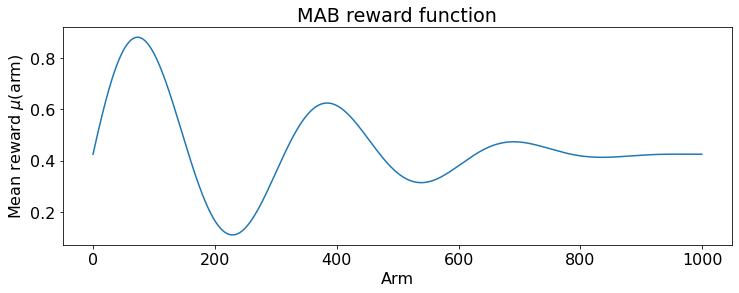

In [6]:
res = 1000
reward_function = np.sin(np.linspace(0,20,res))*(np.linspace(0,20,res)-20)**2
reward_function = (reward_function - reward_function.min())/(reward_function.max()*1.5-reward_function.min())+0.11
plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size': 16})
plt.title("MAB reward function")
plt.ylabel("Mean reward $\mu($arm$)$")
plt.xlabel("Arm")
plt.plot(reward_function)
#plt.savefig(figure_path+"reward_function2.pdf",bbox_inches='tight')
plt.show()

In [7]:
np.random.seed(1234)
mab = {}
mab['gaussian'] = GaussianMAB([(mu,0.1) for mu in np.arange(1,11)*0.06+0.2])
mab['nonstationary_trunc_gauss'] = NonStationaryTruncatedGaussianMAB([(mu,0.1) for mu in np.arange(1,11)*0.06+0.2])
mab['gaussian_lipschitz'] = GaussianMAB(list(zip(reward_function,
                               [0.1]*len(reward_function))))
mab['nonstationary_lipschitz'] = NonStationaryTruncatedGaussianMAB(list(zip(reward_function,
                                       [0.1]*len(reward_function))))
mab['correlated'] = CorrelatedNonstationaryGaussianMAB([0.9]*100, alpha=0.6, forgetting_rate=0.001)

In [8]:
alpha = lambda n: 1/n

policies = {'zooming': {'policy': adaptive_zooming3, 'label': 'Adaptive Zooming', 'data': [], 'params': {'alpha':1000, 'beta':1.0, 'active_set': []}},
            #'zooming': {'policy': adaptive_zooming3, 'label': 'Adaptive Zooming', 'data': [], 'params': {'alpha':950, 'beta':2.5, 'active_set': []}},
            'eps01': {'policy': epsilonGreedy, 'label': '$\epsilon=0.1$', 'data': [], 'params': {'epsilon': 0.1, 'alpha': alpha}},
            'eps02': {'policy': epsilonGreedy, 'label': '$\epsilon=0.2$', 'data': [], 'params': {'epsilon': 0.2, 'alpha': alpha}},
            'ucb1': {'policy': ucb, 'label': '$UCB1\ (\\delta=1/t)$', 'data': [], 'params': {'delta': lambda n: 1/n}},
            'ucb_dn': {'policy': ucb, 'label': '$UCB\ \\delta=1/n$', 'data': [], 'params': {'delta': lambda n: 1/steps}},
            'ucb_dn2': {'policy': ucb, 'label': '$UCB\ \\delta=1/n^2$', 'data': [], 'params': {'delta': lambda n: 1/steps**2}},
            'ucb_sn': {'policy': ucb_slivkins_upfal, 'label': 'UCB Slivkins-Upfal', 'data': [], 'params': {}},
            'exp3': {'policy': exp3, 'label': 'Exp3', 'data': [], 'params': {'eta': 0.1, 'epsilon': 0.825}},
            'exp3_loss_est': {'policy': exp3_loss_est, 'label': 'Exp3_loss_est', 'data': [], 'params': {'eta': 0.25, 'epsilon': 0.1}},
            'exp3_s': {'policy': exp3_s, 'label': 'Exp3_S', 'data': [], 'params': {'eta': 0.125,'epsilon': 0.1, 'beta': 0.25}},
            'exp3_s_loss_est': {'policy': exp3_s, 'label': 'Exp3_S_loss_est', 'data': [], 'params': {'eta': 0.125,'epsilon': 0.1, 'beta': 0.25, 'estimator':'loss'}}
           }

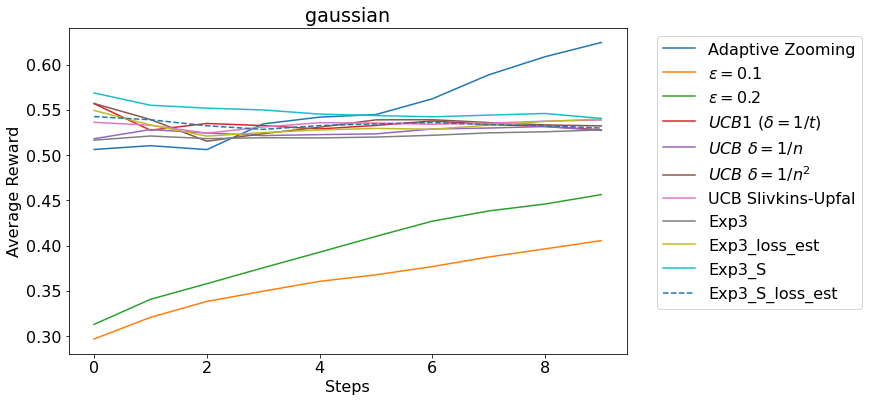

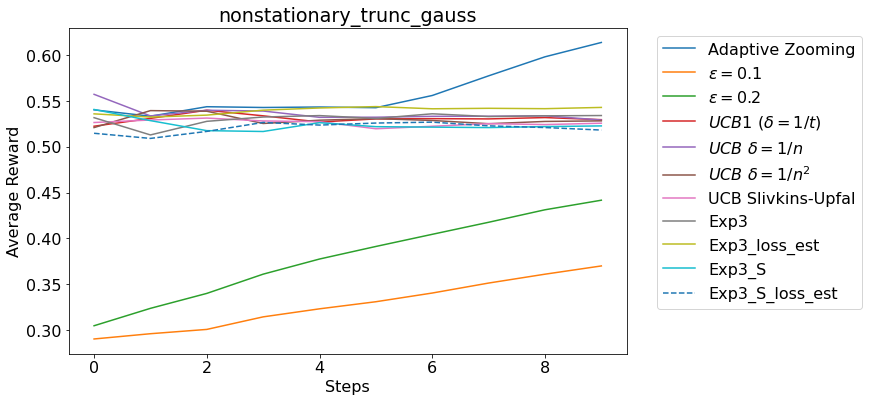

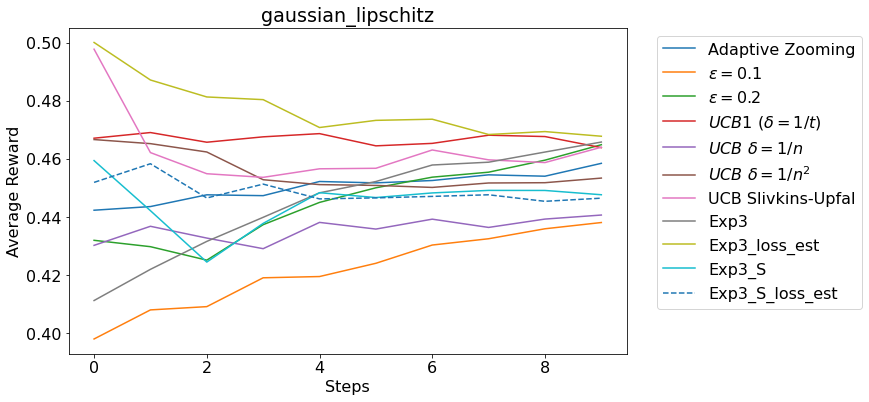

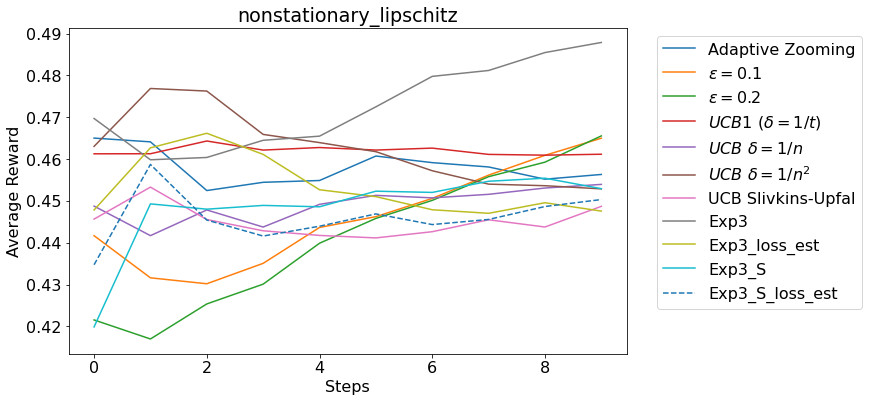

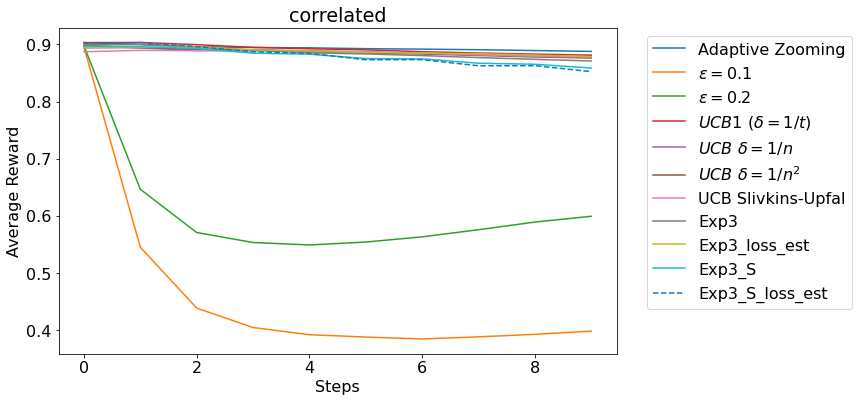

In [9]:
np.random.seed(1234)

## !!! Set steps to ~1000 - 2000 to see the actual results 
steps = 10

lines = ["-","--","-.",":"]

for mab_name, mab_model in mab.items():
    for name, value in policies.items():
        value['data'] = []
    for _ in range(100):
        for name, value in policies.items():
            value['data'] += [run(mab_model, policy=value['policy'], steps = steps, **value['params'])]

    for name, value in policies.items():
        value['data'] = np.array(value['data'])
    
    plt.figure(figsize=(10,6))
    i = 0
    for name, value in policies.items():
        plt.plot(value['data'][:,:,2].mean(axis=0),label=value['label'],linestyle=lines[int(i/10)])
        i+=1
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.title(mab_name)
    #plt.savefig(figure_path+"correlated_mab_hyperopt1.pdf")
    plt.show()